<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/CIFAR_10_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
!nvidia-smi

Mon Jun 15 13:50:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!git clone https://github.com/ayulockin/DataAugmentationTF

Cloning into 'DataAugmentationTF'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 12), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [4]:
%cd DataAugmentationTF/

/content/DataAugmentationTF


In [5]:
!ls

augment_and_mix.py
augmentations.py
CIFAR_10_Baseline_Model.ipynb
CIFAR_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_CutMix_Augmentation.ipynb
CIFAR_10_with_Cutout_Augmentation.ipynb
CIFAR_10_with_Mixup_Augmentation.ipynb
images
models
README.md


In [0]:
%%capture
!pip install wandb

In [0]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_addons as tfa

In [0]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [9]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Download and Prepare Dataset

#### CIFAR-10

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [12]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Visualize

In [0]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

#### Train Set

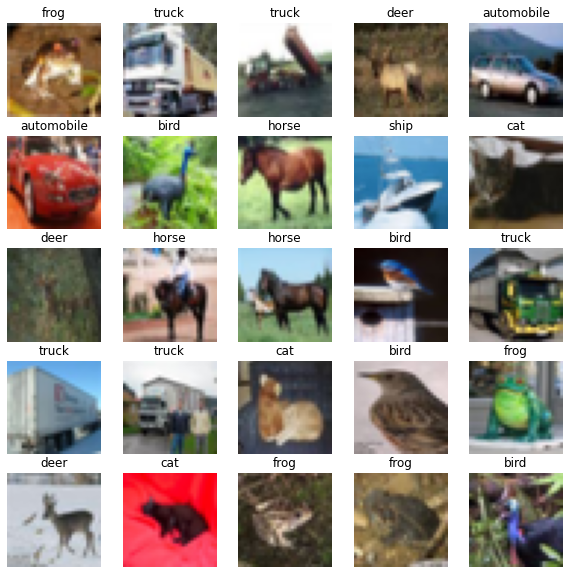

In [14]:
image_batch, label_batch = x_train[:32], y_train[:32]
show_batch(image_batch, label_batch)

#### Test Set

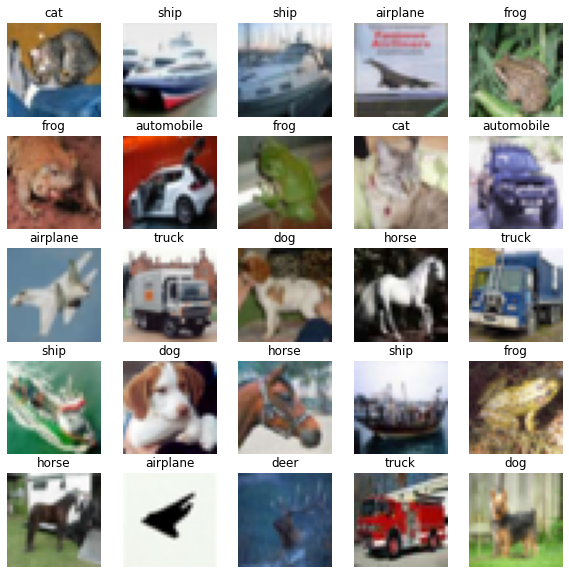

In [15]:
image_batch, label_batch = x_test[:32], y_test[:32]
show_batch(image_batch, label_batch)

# Model

In [0]:
from models.resnet import resnet_v1

In [0]:
def Model():
  return resnet_v1((32,32,3), 20) ## Returns a ResNet20 model.

# Callbacks

In [0]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# Train Baseline

#### Dataloader

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Initialize Model

In [38]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Compile

In [0]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

#### Wandb Init

In [40]:
wandb.init(entity='authors', project='tfaugmentation')

W&B Run: https://app.wandb.ai/authors/tfaugmentation/runs/iv6nbhxk

#### Train

In [41]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 71s 45ms/step - loss: 1.5094 - acc: 0.5106 - val_loss: 1.3216 - val_acc: 0.5769
Epoch 2/100
1563/1563 [==============================] - 69s 44ms/step - loss: 1.1022 - acc: 0.6692 - val_loss: 1.2251 - val_acc: 0.6281
Epoch 3/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.9294 - acc: 0.7315 - val_loss: 1.2010 - val_acc: 0.6567
Epoch 4/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.8306 - acc: 0.7721 - val_loss: 1.1591 - val_acc: 0.6631
Epoch 5/100
1563/1563 [==============================] - 70s 44ms/step - loss: 0.7590 - acc: 0.7982 - val_loss: 1.0223 - val_acc: 0.7190
Epoch 6/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.7047 - acc: 0.8194 - val_loss: 0.9205 - val_acc: 0.7569
Epoch 7/100
1563/1563 [==============================] - 69s 44ms/step - loss: 0.6607 - acc: 0.8358 - val_loss: 1.1740 - val_acc: 0.6964
Epoch 8/100
1563/1563 [==================

#### Save your hardwork

In [42]:
%cd ../../

/


In [0]:
model.save('gdrive/My Drive/DataAugmentation/baseline.h5')

## Quick Evaluate

In [48]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print("Test Error Rate: ", round((1-accuracy)*100, 2), '%')

313/313 [==============================] - 3s 10ms/step - loss: 0.9205 - acc: 0.7569
Test Error Rate:  24.31 %
